# ⚛️ H₂ VQE — Multi-Seed Noise Statistics (Production API)

This notebook studies how **noise** affects **H₂ VQE** using only the
**packaged VQE engine**. It focuses exclusively on **multi-seed statistics**:

- No manual QNodes
- No hand-built ansatz
- No single-seed demos

Instead, everything is driven by:

```python
from vqe.core import run_vqe_multi_seed_noise
```

---

## 🎯 What we compute

For the H₂ molecule using the **UCCSD** ansatz and **Adam** optimizer, we:

1. Sweep **depolarizing noise** strengths and compute:
   - Mean and standard deviation of the energy error (Delta E)
   - Mean and standard deviation of the fidelity vs a reference state
   - Across multiple random seeds
2. Repeat the same analysis for **amplitude damping** noise.

All Hamiltonian construction, ansatz building, devices, caching, and plotting
are handled inside the `vqe` package.

## 1️⃣ Imports and configuration

In [1]:
import numpy as np
import os
import sys

# Allow local import when running from notebooks/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import run_vqe_multi_seed_noise

## 2️⃣ Noise grid and seed selection

We now define:

- A set of **noise probabilities** between 0.0 and 0.10  
- A small set of **random seeds** for averaging  

These are reused for both depolarizing and amplitude-damping studies.

In [2]:
# Noise probabilities in [0.0, 0.10]
noise_levels = np.arange(0.0, 0.11, 0.02)
print("Noise levels:", noise_levels)

# Multiple seeds for statistics
seeds = np.arange(0, 10)
print("Seeds:", seeds)

# Optimizer settings
optimizer = "Adam"
steps = 50
stepsize = 0.2

Noise levels: [0.   0.02 0.04 0.06 0.08 0.1 ]
Seeds: [0 1 2 3 4 5 6 7 8 9]


## 3️⃣ Multi-seed depolarizing noise study

We first study **pure depolarizing noise**:

- `noise_type="depolarizing"`  
- Internally, amplitude damping is set to zero  
- The function:

  `run_vqe_multi_seed_noise(...)`

  will:
  - Run H₂ VQE across seeds and noise levels
  - Compute Delta E and fidelity statistics
  - Produce and save a plot via the shared plotting utilities

The plot is also displayed inline.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__a56aed30983c.json
Step 01/50: E = -1.116684 Ha
Step 02/50: E = -1.136994 Ha
Step 03/50: E = -1.131007 Ha
Step 04/50: E = -1.122704 Ha
Step 05/50: E = -1.130116 Ha
Step 06/50: E = -1.133031 Ha
Step 07/50: E = -1.134500 Ha
Step 08/50: E = -1.134654 Ha
Step 09/50: E = -1.132099 Ha
Step 10/50: E = -1.130839 Ha
Step 11/50: E = -1.133773 Ha
Step 12/50: E = -1.136857 Ha
Step 13/50: E = -1.136815 Ha
Step 14/50: E = -1.134836 Ha
Step 15/50: E = -1.133734 Ha
Step 16/50: E = -1.134460 Ha
Step 17/50: E = -1.135957 Ha
Step 18/50: E = -1.136740 Ha
Step 19/50: E = -1.136507 Ha
Step 20/50: E = -1.136057 Ha
Step 21/50: E = -1.135900 Ha
Step 22/50: E = -1.135937 Ha
Step 23/50: E = -1.136173 Ha
Step 24/50: E = -1.136689 Ha
Step 25/50: E = -1.137069 Ha
Step 26/50: E = -1.136886 Ha
Step 27/50: E = -1.136405 Ha
Step 28/50: E = -1.136270 Ha
Step 29/50: 

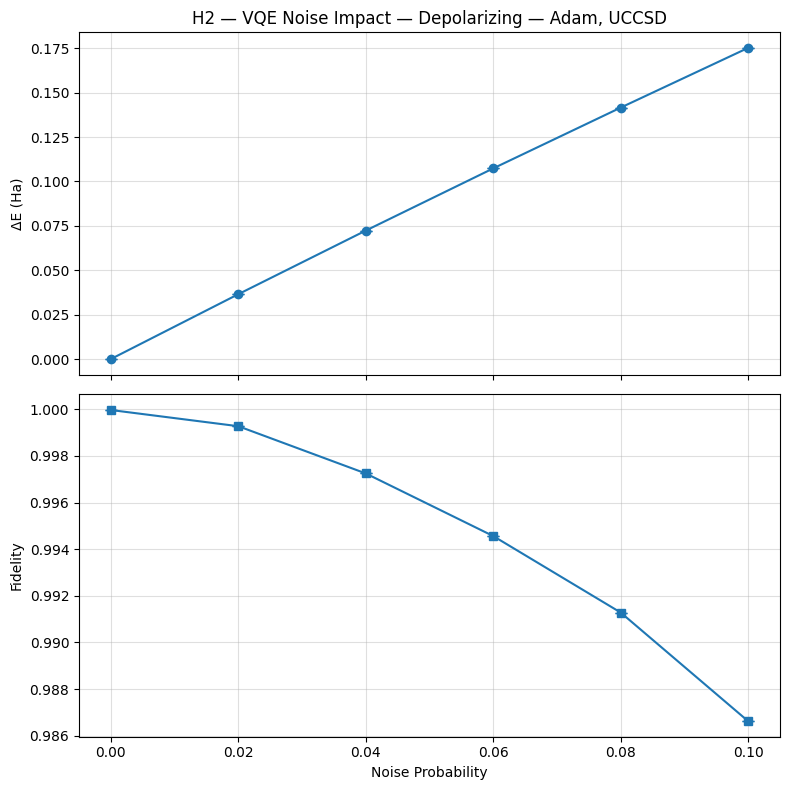


✅ Multi-seed noise study complete for H2


In [3]:
_ = run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=optimizer,
    steps=steps,
    stepsize=stepsize,
    seeds=seeds,
    noise_type="depolarizing",
    depolarizing_probs=noise_levels,
    mapping="jordan_wigner",
    force=False,
    show=True,
)

## 4️⃣ Multi-seed amplitude-damping noise study

Next we study **pure amplitude damping**:

- `noise_type="amplitude"`  
- Internally, depolarizing probabilities are set to zero  
- Again, `run_vqe_multi_seed_noise`:
  - Reuses caching where possible
  - Produces a Delta E vs noise and fidelity vs noise plot with error bars

We reuse the same `noise_levels` and `seeds` for consistency.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s0__a56aed30983c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s1__6f863ea3ee35.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s2__4926dff48095.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s3__b3f185f02013.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s4__882a5ac9f148.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s5__0b753afee98b.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__UCCSD__Adam__VQE__noiseless__s6__0599017ae044.json

📂 Found cache

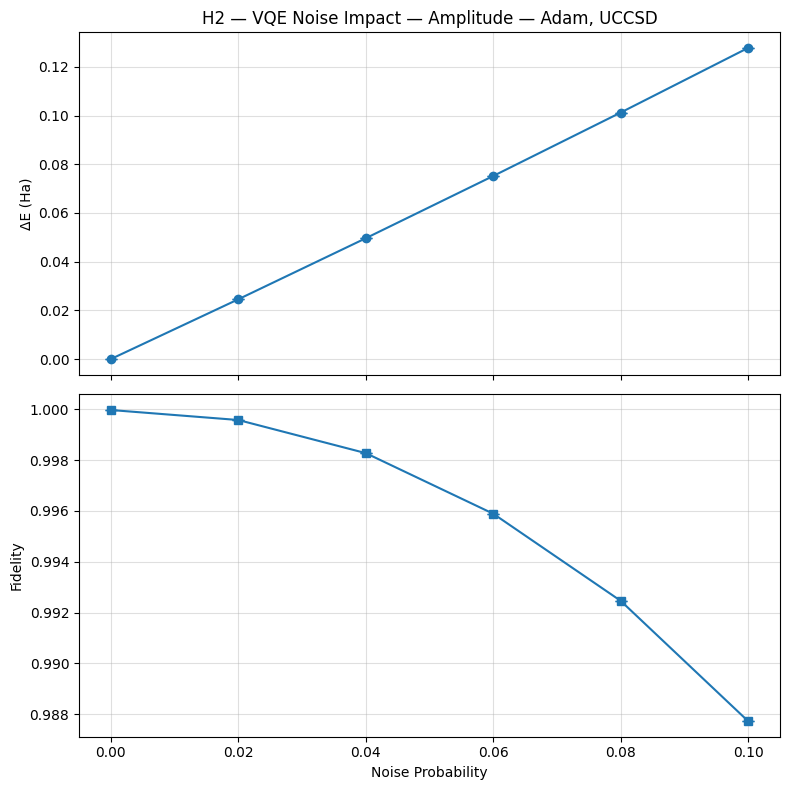


✅ Multi-seed noise study complete for H2


In [4]:
_ = run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=optimizer,
    steps=steps,
    stepsize=stepsize,
    seeds=seeds,
    noise_type="amplitude",
    depolarizing_probs=noise_levels,
    mapping="jordan_wigner",
    force=False,
    show=True,
)


## ✅ Summary

In this notebook you:

- Used **only** the production VQE API, via `run_vqe_multi_seed_noise`, to study
  the effect of noise on **H₂ VQE**.
- Ran **multi-seed depolarizing noise** sweeps to obtain:
  - Mean and standard deviation of Delta E
  - Mean and standard deviation of fidelity
  as functions of the noise strength.
- Repeated the same analysis for **amplitude damping** noise.
